## First, we need to preprocess the data.
#### 1. Use FDA_Drug, ChEMBL, ZINC, and GDB17 files to construct positive and negative samples for the dataset
#### Use [41, 42, 43, 44, 45, 46, 47, 48, 49, 50] as random seeds for random sampling to build positive and negative samples, improving the stability of feature selection

In [1]:
import pandas as pd
from sklearn.utils import shuffle

RANDOM_SEED = 50

fda_df = pd.read_csv('FDA_Drug_predictions.csv')
fda_df['y'] = 1

chembl_df = pd.read_csv('ChEMBL_predictions.csv')
gdb17_df = pd.read_csv('GDB17_predictions.csv')
zinc_df = pd.read_csv('ZINC_predictions.csv')

chembl_sample = shuffle(chembl_df, random_state=RANDOM_SEED).head(1000)
gdb17_sample = shuffle(gdb17_df, random_state=RANDOM_SEED).head(1000)
zinc_sample = shuffle(zinc_df, random_state=RANDOM_SEED).head(1000)

chembl_sample['y'] = 0
gdb17_sample['y'] = 0
zinc_sample['y'] = 0

combined_df = pd.concat([fda_df, chembl_sample, gdb17_sample, zinc_sample], ignore_index=True)

combined_df.to_csv('combined_predictions.csv', index=False)

print("Data has been successfully merged and saved as combined_predictions.csv")

Data has been successfully merged and saved as combined_predictions.csv


### Next, we need to remove conventional physicochemical properties and only perform feature selection on ADMETsar3.0 features.
### Need to remove 9 conventional properties: MW, nAtom, nHet, nRing, nRot, HBA, HBD, TPSA, SlogP
### Also remove 17 eco-environmental related features, including: subcapitata_toxicity
- Crustaceans_toxicity
- magna_toxicity  
- Fish_toxicity
- Fathead_minnow_toxicity
- Bluegill_sunfish_toxicity
- Rainbow_trout_toxicity
- Sheepshead_minnow_toxicity
- pyriformis_toxicity_c
- pyriformis_toxicity
- Honey_bee_toxicity
- Colinus_virginanus_toxicity
- Anas_platyrhynchos_toxicity
- BCF_c
- BCF
- Biodegradability
- Photoinduced_toxicity

### Then remove 9 cosmetics-related features:
- Eye_corrosion
- Eye_irritation
- Skin_corrosion
- Skin_irritation
- Skin_sensitisation
- Photoinduced_toxicity
- Phototoxicity_Photoirritation
- Photoallergy



In [2]:
import pandas as pd

columns_to_drop = [
    'MW', 'nAtom', 'nHet', 'nRing', 'nRot', 'HBA', 'HBD', 'TPSA', 'SlogP',
    'subcapitata_toxicity',
    'Crustaceans_toxicity', 
    'magna_toxicity',
    'Fish_toxicity',
    'Fathead_minnow_toxicity',
    'Bluegill_sunfish_toxicity',
    'Rainbow_trout_toxicity',
    'Sheepshead_minnow_toxicity',
    'pyriformis_toxicity_c',
    'pyriformis_toxicity',
    'Honey_bee_toxicity',
    'Colinus_virginanus_toxicity',
    'Anas_platyrhynchos_toxicity',
    'BCF_c',
    'BCF',
    'Biodegradability',
    'Photoinduced_toxicity'
    'Eye_corrosion',
    'Eye_irritation', 
    'Skin_corrosion',
    'Skin_irritation',
    'Skin_sensitisation',
    'Photoinduced_toxicity',
    'Phototoxicity_Photoirritation',
    'Photoallergy'
]

combined_df = pd.read_csv('combined_predictions.csv')

current_columns = combined_df.columns.tolist()
print("Original column count:", len(current_columns))
print("Original column names:", current_columns)

existing_columns_to_drop = [col for col in columns_to_drop if col in combined_df.columns]
print("Columns to be deleted:", existing_columns_to_drop)

combined_df_cleaned = combined_df.drop(columns=existing_columns_to_drop)

cleaned_columns = combined_df_cleaned.columns.tolist()
print("Column count after deletion:", len(cleaned_columns))
print("Column names after deletion:", cleaned_columns)

combined_df_cleaned.to_csv('combined_predictions_cleaned.csv', index=False)

print("Data has been successfully cleaned and saved as combined_predictions_cleaned.csv")

Original column count: 123
Original column names: ['SMILES', 'MW', 'nAtom', 'nHet', 'nRing', 'nRot', 'HBA', 'HBD', 'TPSA', 'SlogP', 'logS', 'QED', 'Lipinski_rule', 'Pfizer_rule', 'GSK_rule', 'logP', 'pKa', 'Acidic_pKa', 'Basic_pKa', 'Caco_2_c', 'Caco_2', 'HIA', 'MDCK', 'F50', 'F30', 'F20', 'BBB', 'OATP1B1_inhibitor', 'OATP1B3_inhibitor', 'OATP2B1_inhibitor', 'OCT1_inhibitor', 'OCT2_inhibitor', 'BCRP_inhibitor', 'BSEP_inhibitor', 'MATE1_inhibitor', 'Pgp_inhibitor', 'Pgp_substrate', 'PPB', 'VDss', 'CYP1A2_inhibitor', 'CYP3A4_inhibitor', 'CYP2B6_inhibitor', 'CYP2C9_inhibitor', 'CYP2C19_inhibitor', 'CYP2D6_inhibitor', 'CYP1A2_substrate', 'CYP3A4_substrate', 'CYP2B6_substrate', 'CYP2C9_substrate', 'CYP2C19_substrate', 'CYP2D6_substrate', 'HLM', 'RLM', 'UGT_substrate', 'CLp_c', 'CLr', 'T50', 'MRT', 'Neurotoxicity', 'DILI', 'hERG_1uM', 'hERG_10uM', 'hERG_30uM', 'hERG_1_10uM', 'hERG_10_30uM', 'Respiratory_toxicity', 'Nephrotoxicity', 'Eye_corrosion', 'Eye_irritation', 'Skin_corrosion', 'Skin_i

筛选出需要进行特征选择的特征后，先对数据异常值进行均值填充,为什么要均值填充,因为我们有97个端点,假设每个端点的异常值都为0.1%,也就是99.5%都可以通过,删除后剩下的数据也会变为0.995的一百次方,也就是(0.6057)损失太多数据,这被我们认为是不合适的,因此采用均值填充方式处理.
我们进行数据的归一化
对所有的特征同时进行min-max归一化，使得所有的特征都在0-1之间，进行后续的特征筛选


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('combined_predictions_cleaned.csv')

columns_to_keep = ['SMILES', 'Source', 'y']

rule_columns = ['Lipinski_rule', 'Pfizer_rule', 'GSK_rule']

df[rule_columns] = df[rule_columns].replace({'Not accept': 0, 'Accept': 1})

columns_to_normalize = [col for col in df.columns if col not in columns_to_keep + rule_columns]

def impute_outliers_with_mean(df, columns):
    categorical_columns = [col for col in columns if set(df[col].unique()).issubset({0, 1, 0.0, 1.0})]
    numerical_columns = [col for col in columns if col not in categorical_columns]
    
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mean_value = df[col].mean()
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), mean_value, df[col])
    return df

df_cleaned = impute_outliers_with_mean(df, columns_to_normalize)

scaler = MinMaxScaler()

df_cleaned[columns_to_normalize] = scaler.fit_transform(df_cleaned[columns_to_normalize])

final_columns = columns_to_keep + rule_columns + columns_to_normalize
df_final = df_cleaned[final_columns]

df_final.to_csv('preprocessed_predictions.csv', index=False)

print("Data has been preprocessed and saved as preprocessed_predictions.csv")

C:\Users\beiweisanyecao\AppData\Local\Temp\ipykernel_12884\1257034015.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rule_columns] = df[rule_columns].replace({'Not accept': 0, 'Accept': 1})


Data has been preprocessed and saved as preprocessed_predictions.csv


现在我们已经成功的将数据预处理完毕,下面进行随机森林特征选择

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from scipy.stats import chi2_contingency

output_dir = f'RandomForestClassifier_{RANDOM_SEED}'
os.makedirs(output_dir, exist_ok=True)

data = pd.read_csv('preprocessed_predictions.csv')

X = data.drop(['y', 'SMILES', 'Source'], axis=1)
y = data['y']

X = X.apply(pd.to_numeric, errors='coerce')

rf_fold_results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_features_list = []
top_n = 30

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    rf_importances = pd.Series(rf.feature_importances_, index=X.columns)
    rf_importances = rf_importances.sort_values(ascending=False)
    
    rf_selected = rf_importances.index[:top_n].tolist()
    rf_features_list.extend(rf_selected)
    
    rf_fold_results.append({
        'fold': fold,
        'feature_importances': rf_importances
    })

rf_features_counts = pd.Series(rf_features_list).value_counts()

plt.figure(figsize=(10, 8))
sns.barplot(x=rf_features_counts.values, y=rf_features_counts.index)
plt.title('Random Forest Features Selection Frequency')
plt.xlabel('Frequency')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'RandomForestFeaturesSelectionFrequency.png'))
plt.close()

rf_final_selected_features = rf_features_counts.index[:top_n].tolist()

for result in rf_fold_results:
    fold = result['fold']
    importances = result['feature_importances']
    importances_df = importances.reset_index()
    importances_df.columns = ['Feature', 'Importance']
    importances_df.to_csv(os.path.join(output_dir, f'rf_fold_{fold}_importances.csv'), index=False)




Starting Mutual Information Feature Selection...
Starting Mutual Information Feature Selection for fold 1...
Mutual Information Feature Selection for fold 1 completed, results saved to Mutual_Information_50\mi_fold_1_importances.csv
Starting Mutual Information Feature Selection for fold 2...
Mutual Information Feature Selection for fold 2 completed, results saved to Mutual_Information_50\mi_fold_2_importances.csv
Starting Mutual Information Feature Selection for fold 3...
Mutual Information Feature Selection for fold 3 completed, results saved to Mutual_Information_50\mi_fold_3_importances.csv
Starting Mutual Information Feature Selection for fold 4...
Mutual Information Feature Selection for fold 4 completed, results saved to Mutual_Information_50\mi_fold_4_importances.csv
Starting Mutual Information Feature Selection for fold 5...
Mutual Information Feature Selection for fold 5 completed, results saved to Mutual_Information_50\mi_fold_5_importances.csv
Mutual Information feature sel

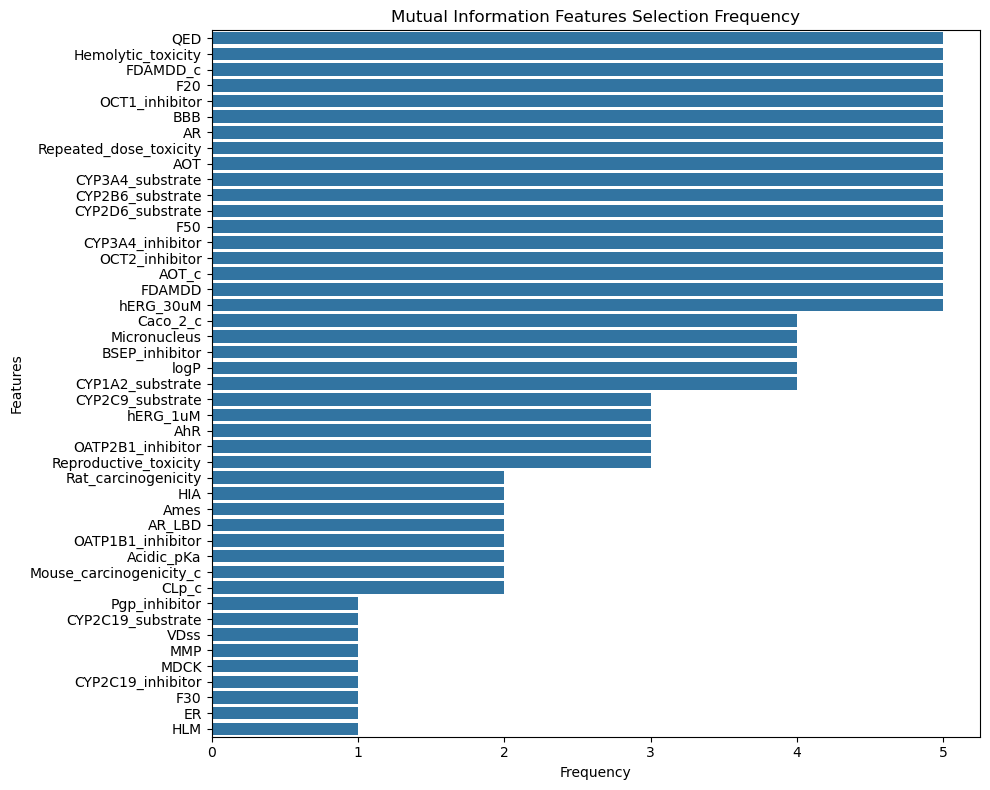

Mutual Information final top 30 selected features:
['QED', 'Hemolytic_toxicity', 'FDAMDD_c', 'F20', 'OCT1_inhibitor', 'BBB', 'AR', 'Repeated_dose_toxicity', 'AOT', 'CYP3A4_substrate', 'CYP2B6_substrate', 'CYP2D6_substrate', 'F50', 'CYP3A4_inhibitor', 'OCT2_inhibitor', 'AOT_c', 'FDAMDD', 'hERG_30uM', 'Caco_2_c', 'Micronucleus', 'BSEP_inhibitor', 'logP', 'CYP1A2_substrate', 'CYP2C9_substrate', 'hERG_1uM', 'AhR', 'OATP2B1_inhibitor', 'Reproductive_toxicity', 'Rat_carcinogenicity', 'HIA']

Comprehensively selected features (intersection):
['hERG_1uM', 'BSEP_inhibitor', 'AOT_c', 'Micronucleus', 'CYP3A4_substrate', 'BBB', 'OATP2B1_inhibitor', 'QED', 'CYP2C9_substrate', 'FDAMDD_c', 'CYP3A4_inhibitor', 'Reproductive_toxicity', 'CYP2D6_substrate', 'CYP1A2_substrate', 'AhR', 'CYP2B6_substrate', 'FDAMDD', 'F50', 'Hemolytic_toxicity', 'OCT2_inhibitor']


In [5]:
# -------------------- Mutual Information Feature Selection --------------------
import os
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

print("\nStarting Mutual Information Feature Selection...")

# Define output directory
mi_output_dir = f'Mutual_Information_{RANDOM_SEED}'
os.makedirs(mi_output_dir, exist_ok=True)

mi_features_list = []

# Define top N features
top_n = 30

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    print(f"Starting Mutual Information Feature Selection for fold {fold}...")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Calculate mutual information
    mi = mutual_info_classif(X_train, y_train, random_state=42)
    mi_series = pd.Series(mi, index=X.columns)
    mi_series = mi_series.sort_values(ascending=False)
    
    # Select top N features
    mi_selected = mi_series.index[:top_n].tolist()
    mi_features_list.extend(mi_selected)
    
    # Save mutual information results for the current fold
    mi_fold_df = mi_series.reset_index()
    mi_fold_df.columns = ['Feature', 'MutualInformation']
    mi_fold_df.to_csv(os.path.join(mi_output_dir, f'mi_fold_{fold}_importances.csv'), index=False)
    
    print(f"Mutual Information Feature Selection for fold {fold} completed, results saved to {os.path.join(mi_output_dir, f'mi_fold_{fold}_importances.csv')}")

# Count the occurrences of each feature
mi_features_counts = pd.Series(mi_features_list).value_counts()
print(f"Mutual Information feature selection occurrence counts in five-fold cross-validation:\n{mi_features_counts}")

# Visualize the stability of feature selection
plt.figure(figsize=(10, 8))
sns.barplot(x=mi_features_counts.values, y=mi_features_counts.index)
plt.title('Mutual Information Features Selection Frequency')
plt.xlabel('Frequency')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig(os.path.join(mi_output_dir, 'MutualInfoFeaturesSelectionFrequency.png'))
plt.show()

# Get the final selected features (top 30 most frequent)
mi_final_selected_features = mi_features_counts.index[:top_n].tolist()
print(f"Mutual Information final top {top_n} selected features:\n{mi_final_selected_features}")

# -------------------- Comprehensive Feature Selection --------------------
# Take the intersection of the two methods
selected_features = list(set(rf_final_selected_features) & set(mi_final_selected_features))
print(f"\nComprehensively selected features (intersection):\n{selected_features}")